In [ ]:
from dotenv import load_dotenv

load_dotenv()

### Input & Output State

In [13]:
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph

model = ChatOpenAI()

In [14]:
from typing import TypedDict


class ChatMessages(TypedDict):
    question: str
    answer: str
    llm_calls: int

In [15]:
def call_model(state: ChatMessages):
    question = state["question"]
    llm_calls = state.get("llm_calls", 0)
    state["llm_calls"] = llm_calls + 1
    print("LLM_CALLS:", state["llm_calls"])
    response = model.invoke(input=question)
    state["answer"] = response.content
    return state

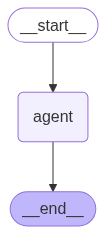

In [16]:
workflow = StateGraph(ChatMessages)

workflow.add_edge(START, "agent")
workflow.add_node("agent", call_model)
workflow.add_edge("agent", END)

graph = workflow.compile()
graph

In [ ]:
graph.invoke(input={"question": "Whats the highest mountain in the world?"})

In [17]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


class InputState(TypedDict):
    question: str


# class PrivateState(TypedDict):
#     llm_calls: int


class OutputState(TypedDict):
    answer: str


class OverallState(InputState, OutputState):
    pass

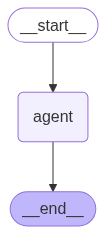

In [18]:
workflow = StateGraph(OverallState, input=InputState, output=OutputState)

workflow.add_edge(START, "agent")
workflow.add_node("agent", call_model)
workflow.add_edge("agent", END)

graph = workflow.compile()
graph

In [19]:
graph.invoke({"question": "Whats the highest mountain in the world?"})

LLM_CALLS: 1


{'answer': 'Mount Everest, located in the Himalayas on the border between Nepal and Tibet, is the highest mountain in the world with a peak reaching 29,032 feet (8,848 meters) above sea level.'}

### Add runtime configuration

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.config import RunnableConfig
from langchain.schema import SystemMessage, HumanMessage


def call_model(state: OverallState, config: RunnableConfig):
    language = config["configurable"].get("language", "English")
    system_message_content = "Respond in {}".format(language)
    system_message = SystemMessage(content=system_message_content)
    messages = [system_message, HumanMessage(content=state["question"])]
    response = model.invoke(messages)
    return {"answer": response}

In [ ]:
workflow = StateGraph(ChatMessages)

workflow.add_edge(START, "agent")
workflow.add_node("agent", call_model)
workflow.add_edge("agent", END)

graph = workflow.compile()

In [ ]:
config = {"configurable": {"language": "Spanish"}}
graph.invoke({"question": "What's the highest mountain in the world?"}, config=config)

In [ ]:
config = {"configurable": {"language": "German"}}
graph.invoke({"question": "What's the highest mountain in the world?"}, config=config)